In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"
import scipy.interpolate
from scipy.ndimage import zoom

mm = 1E-3
C = scipy.constants.c

def set_font(fontsize=18, font="Times New Roman"):
    rc = {"font.size" : fontsize,
    "font.family" : font,
    "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
set_font(fontsize=15)

def next_pow_2(x):
    return int(2**np.ceil(np.log2(x)))

def fft_resample(img, Nx, Ny, Nz):
    '''
    Resamples image img by padding or truncating in the Fourier domain.

    '''
    img = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(img)))
    scal = img.size
    img = padortruncate3d(img, Nx, Ny, Nz)
    scal = img.size / scal
    img = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(img)))*scal

    return img
def resample(im, scale, xs, ys, zs):
    im = zoom(im, (scale, scale, scale))
    xs = np.linspace(np.amin(xs), np.amax(xs), im.shape[1])
    ys = np.linspace(np.amin(ys), np.amax(ys), im.shape[0])
    zs = np.linspace(np.amin(zs), np.amax(zs), im.shape[2])
    Xs, Ys, Zs = np.meshgrid(xs, ys, zs, indexing='xy')
    return im, Xs, Ys, Zs

def padortruncate3d(array, dx, dy, dz, val_bg=0):
    '''
    Pads (with value val_bg) or truncates array depending on whether array dimensions are great than or less than (dx, dy)

    '''
    dx = int(dx)
    dy = int(dy)
    dz = int(dz)
    nx = max((dx-array.shape[0])//2, 0)
    ny = max((dy-array.shape[1])//2, 0)
    nz = max((dz-array.shape[2])//2, 0)
    px = max((array.shape[0]-dx)//2, 0)
    py = max((array.shape[1]-dy)//2, 0)
    pz = max((array.shape[2]-dz)//2, 0)
    newarray = val_bg * np.ones((dx, dy, dz), dtype=array.dtype)
    cx = min(array.shape[0], dx)
    cy = min(array.shape[1], dy)
    cz = min(array.shape[2], dz)
    newarray[nx:nx+cx, ny:ny+cy, nz:nz+cz] = array[px:px+cx, py:py+cy, pz:pz+cz]

    return newarray

def G(k, R):
    return np.exp(-1j*k*R)/R

def interp1d(x_new, x, y, kind='linear'):
    f_real = scipy.interpolate.interp1d(x, np.real(y), kind=kind, bounds_error=False, fill_value=0)
    f_imag = scipy.interpolate.interp1d(x, np.imag(y), kind=kind, bounds_error=False, fill_value=0)
    f_interp = f_real(x_new) + 1j*f_imag(x_new)
    return f_interp

### Load data & antenna coordinates

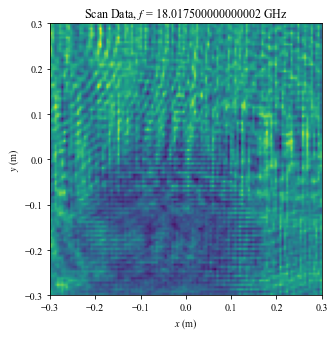

In [2]:
d_antennas = .035        # distance between tx/rx antennas
fc = 22E9
bw = 8E9

mat = scipy.io.loadmat(r'C:\Users\User\Documents\Metacept\Projects\TWI\Code\Jonah_SAR\Data\Baseline_InsideWall_60X60cm_RealWallMeasSeries_23-Feb-2019_1_29.mat')
mat = mat['data']

f = mat['f'][0,0][0,:]
f_indx = np.argwhere(np.abs(f-fc)<=bw/2)[:,0]
f = f[f_indx]
lam = C/f
k = 2*np.pi/lam
Xa = np.flip(mat['X'][0,0]*mm, axis=(0,1))   # flipping to recover right-handed coordinate systems
Ya = np.flip(mat['Y'][0,0]*mm, axis=(0,1))       # flipping because origin of scan stage was at top left
Xa = Xa - np.mean(Xa)
Ya = Ya - np.mean(Ya)
Za = np.zeros_like(Xa)
xa = np.unique(Xa)
ya = np.unique(Ya)
delta_xa = xa[1] - xa[0]
delta_ya = ya[1] - ya[0]
measurements = np.flip(mat['measurements'][0,0], axis=(0,1))
z_offset = 0.56

## correct for probe phase
mat = scipy.io.loadmat(r'C:\Users\User\Documents\Metacept\Projects\TWI\Experiment\Monostatic Experiments - Shared\Data\Horn_Calibration_221109\horn_phase_9GHz.mat')
f_exp = mat['f'][0,:]
phase_error_exp = mat['horn_phase'][0,:]
measurements = measurements / np.exp(1j*2*phase_error_exp)[None,None,:]     # experimental horn data

# ### load background
# mat = scipy.io.loadmat(r'..\..\..\Data\background_2022-11-11.mat')
# bg = np.flip(mat['measurements'], axis=(0,1))

# ### subtract background from measurements
# measurements = measurements - bg

set_font(fontsize=15)
fig = plt.figure(figsize=(5,5))
plt.imshow(np.real(measurements[:,:,0]),
           extent=(np.amin(xa), np.amax(xa), np.amin(ya), np.amax(ya)),
           origin='lower')
plt.title('Scan Data, $f$ = {} GHz'.format(f[0]*1E-9))
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.show()

# ### truncate scan
Lxa_new = 0.6
Lya_new = 0.6

indx_center_x = xa.size//2
indx_center_y = ya.size//2

indx_x = (xa>=-Lxa_new/2) * (xa<=Lxa_new/2)
indx_y = (ya>=-Lya_new/2) * (ya<=Lya_new/2)
Xa = Xa[indx_y,:][:,indx_x]
Ya = Ya[indx_y,:][:,indx_x]
Za = np.zeros_like(Xa)
measurements = measurements[indx_y,:,:][:,indx_x,:][:,:,f_indx]

xa_center = np.mean(Xa)
ya_center = np.mean(Ya)

Na = Xa.size
Nf = f.size
M = Na*Nf                           # total number of measurements
Lxa = np.amax(Xa) - np.amin(Xa)
Lya = np.amax(Ya) - np.amin(Ya)



### Define reconstruction region

In [3]:
Lxs = 1
Lys = 1
Lzs = 0.5

cr_res_x = np.amin(lam)*z_offset/(2*Lxa)
cr_res_y = np.amin(lam)*z_offset/(2*Lya)
r_res_z = C/bw

# delta_xs = cr_res_x/2
# delta_ys = cr_res_y/2
# delta_zs = r_res_z/2
delta_xs = np.amin(lam)
delta_ys = np.amin(lam)
delta_zs = np.amin(lam)

xs_offset = -0.1
ys_offset = -0.2
zs_offset = z_offset

### Reconstruct

In [4]:
pad_x = next_pow_2(max(int(Lxs // delta_xa), measurements.shape[1]))
pad_y = next_pow_2(max(int(Lys // delta_ya), measurements.shape[0]))

measurements_pad = padortruncate3d(measurements, pad_x, pad_y, measurements.shape[2])
# measurements_pad = measurements

Nx_pad = measurements_pad.shape[1]
Ny_pad = measurements_pad.shape[0]
measurements_ft = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(
                        measurements_pad,
                        axes=(0,1)), axes=(0,1)), axes=(0,1))
# measurements_ft = padortruncate3d(measurements_ft, pad_x, pad_y, measurements.shape[2])
# Nx_pad = measurements_ft.shape[1]
# Ny_pad = measurements_ft.shape[0]
delta_kx = 2*np.pi/(delta_xa * Nx_pad)
delta_ky = 2*np.pi/(delta_ya * Ny_pad)
kx = np.arange(-np.floor(Nx_pad/2), np.ceil(Nx_pad/2)) * delta_kx
ky = np.arange(-np.floor(Ny_pad/2), np.ceil(Ny_pad/2)) * delta_ky
Kx, Ky, K = np.meshgrid(kx.astype(np.complex128), ky.astype(np.complex128), k.astype(np.complex128), indexing='xy')
Kz = np.sqrt(4*K**2 - Kx**2 - Ky**2)
# measurements_ft[np.imag(Kz)!=0] = 0
# Kz[np.imag(Kz)!=0] = 0
Kz = np.real(Kz)

filt = np.nan_to_num(K / Kz**2)
# measurements_ft = measurements_ft * np.exp(1j * Kx * xs_offset) * np.exp(1j * Ky * ys_offset) * np.exp(1j * Kz * zs_offset) / filt
measurements_ft = measurements_ft * np.exp(1j * Kz * zs_offset)

radius = 10
measurements_ft[(Kx**2 + Ky**2 <= radius**2)] = 0

delta_kz = 2*np.pi/Lzs
# kz_linear = np.arange(np.amin(Kz), np.amax(Kz), delta_kz)
Nkz = (np.amax(Kz) - np.amin(Kz))//delta_kz
kz_linear = np.linspace(np.amin(Kz), np.amax(Kz), next_pow_2(Nkz))

measurements_stolt = np.zeros((measurements_ft.shape[0], measurements_ft.shape[1], kz_linear.size), dtype=np.complex128)
for i in range(measurements_ft.shape[0]):
    for j in range(measurements_ft.shape[1]):
        if (Kz[i,j,Kz[i,j,:]!=0]).size >= 2:
            measurements_stolt[i,j,:] = interp1d(kz_linear, Kz[i,j,Kz[i,j,:]!=0], measurements_ft[i,j,Kz[i,j]!=0], kind='cubic')
measurements_stolt = np.nan_to_num(measurements_stolt)

%matplotlib qt
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax1.imshow(np.log10(np.abs(measurements_stolt[measurements_stolt.shape[0]//2,:,:])))
ax2 = fig.add_subplot(132)
ax2.imshow(np.log10(np.abs(measurements_stolt[:,measurements_stolt.shape[1]//2,:])))
ax3 = fig.add_subplot(133)
ax3.imshow(np.log10(np.abs(measurements_stolt[:,:,measurements_stolt.shape[2]//2])))

Lkx = 2*np.pi / delta_xs
Lky = 2*np.pi / delta_ys
Lkz = 2*np.pi / delta_zs

im = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(measurements_stolt)))

xs = np.linspace(-Lxs/2, Lxs/2, im.shape[1]) + xs_offset
ys = np.linspace(-Lys/2, Lys/2, im.shape[0]) + ys_offset
zs = np.linspace(-Lzs/2, Lzs/2, im.shape[2]) + zs_offset
Xs, Ys, Zs = np.meshgrid(xs, ys, zs, indexing='xy')

C:\Users\User\AppData\Local\Temp\ipykernel_6936\3835385003.py:25: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Temp\ipykernel_6936\3835385003.py:25: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\User\AppData\Local\Temp\ipykernel_6936\3835385003.py:47: RuntimeWarning:

divide by zero encountered in log10

C:\Users\User\AppData\Local\Temp\ipykernel_6936\3835385003.py:49: RuntimeWarning:

divide by zero encountered in log10

C:\Users\User\AppData\Local\Temp\ipykernel_6936\3835385003.py:51: RuntimeWarning:

divide by zero encountered in log10



In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax1.imshow(np.log10(np.abs(measurements_ft[measurements_ft.shape[0]//2,:,:])))
ax2 = fig.add_subplot(132)
ax2.imshow(np.log10(np.abs(measurements_ft[:,measurements_ft.shape[1]//2,:])))
ax3 = fig.add_subplot(133)
ax3.imshow(np.log10(np.abs(measurements_ft[:,:,measurements_ft.shape[2]//2])))

C:\Users\User\AppData\Local\Temp\ipykernel_22344\968963159.py:3: RuntimeWarning:

divide by zero encountered in log10

C:\Users\User\AppData\Local\Temp\ipykernel_22344\968963159.py:5: RuntimeWarning:

divide by zero encountered in log10

C:\Users\User\AppData\Local\Temp\ipykernel_22344\968963159.py:7: RuntimeWarning:

divide by zero encountered in log10



### Plot

In [5]:
# scale = 2
# im, Xs, Ys, Zs = resample(im, scale, xs, ys, zs)

# im_2d = np.abs(np.mean(im, 2))**2
# im_2d = np.mean(np.abs(im)**2, 2)
# im_2d = im_2d/np.amax(im_2d)
im_2d = np.abs(im[:,:,im.shape[2]//2])**2
# im_2d = 10*np.log10(im_2d/np.amax(im_2d))

im_2d = np.flipud(im_2d)
im_2d = im_2d/np.amax(im_2d)
# %matplotlib qt
set_font(fontsize=15)
plt.figure()
plt.imshow(im_2d,
           extent=(np.amin(xs), np.amax(xs), np.amin(ys), np.amax(ys)),
           origin='lower',
           cmap='turbo')
# plt.clim(-10, 0)
plt.clim(.0, 1)
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.title('Reconstruction')
plt.colorbar(label='dB')
plt.show()

##### 3D plot

In [6]:
x_interp = np.linspace(np.amin(xs), np.amax(xs), im.shape[0])
y_interp = np.linspace(np.amin(ys), np.amax(ys), im.shape[1])
z_interp = np.linspace(np.amin(zs), np.amax(zs), im.shape[2])
X_interp, Y_interp, Z_interp = np.meshgrid(x_interp, y_interp, z_interp, indexing='ij')

im_plot = np.abs(im)**2
im_plot = im_plot/np.amax(im_plot)
# im_plot = 10*np.log10(im_plot/np.amax(im_plot))

surface_count = 20
opacity = .1
isomin = 0
isomax = 1

fig = go.Figure(data=go.Volume(
                    x=Z_interp.flatten(),
                    y=X_interp.flatten(),
                    z=Y_interp.flatten(),
                    value=im_plot.flatten(),
                    name='Reconstruction',
                    isomin=isomin,
                    isomax=isomax,
                    opacity=opacity, # needs to be small to see through all surfaces
                    surface_count=surface_count, # needs to be a large number for good volume rendering
                    colorscale='Turbo',
                    caps= dict(x_show=False, y_show=False, z_show=False),
                    opacityscale='uniform'
                ))
fig.show()

In [ ]:
scipy.io.savemat(r'C:\Users\User\Documents\Metacept\Projects\TWI\Experiment\Monostatic Experiments - Shared\Data\Image_Data\wall1_drywall_test.mat',
                 {'X': X_interp,
                  'Y': Y_interp,
                  'Z': Z_interp,
                  'image': im})